In [1]:
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

a:\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Cross-validation with GSE180286 dataset with percent.mito
## using saved model from GSE176078 new one

In [3]:
# This is the relative path of the assets directory, if the assets are in another location please change the path accordingly.
assets = "../assets"

In [4]:
# Load trained model
model_path = f"{assets}/GSE176078/GSE176078_xgboost_model.pkl"
xgb_model = joblib.load(model_path)

In [5]:
data_path = f"{assets}/GSE180286/GSE180286_obs.csv"
df = pd.read_csv(data_path)

In [ ]:
# Define features used in model
features = [
    "apoptosis_score", "oxphos_score",
    "pct_counts_ribo", "nCount_RNA", "cnv_score",
    "proto_oncogenescore", "S_score", "G2M_score", "percent.mito"
]

In [7]:
df.columns

Index(['Unnamed: 0', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'percent.mito',
       'cnv_reference', 'cnv_score', 'nCount_RNA', 'S_score', 'G2M_score',
       'phase', 'oxphos_score', 'apoptosis_score', 'proto_oncogenescore',
       'pct_counts_ribo'],
      dtype='object')

In [8]:
# Drop missing values and predict
df = df.dropna(subset=features)

# Use model's internal feature order
X_val = df[xgb_model.feature_names_in_]

# Predict
df["tumor_prob_mito"] = xgb_model.predict_proba(X_val)[:, 1]
df["tumor_pred_mito"] = (df["tumor_prob_mito"] > 0.5).astype(int)
df["tumor_pred_label_mito"] = df["tumor_pred_mito"].map({0: "Predicted Normal", 1: "Predicted Tumor"})

# Data is ready for further analysis in memory
print("Predictions completed and stored in df")

Predictions completed and stored in df


In [9]:
df.head()

,Unnamed: 0,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,S_score,G2M_score,phase,oxphos_score,apoptosis_score,proto_oncogenescore,pct_counts_ribo,tumor_prob_mito,tumor_pred_mito,tumor_pred_label_mito
0,GGATAAGGGTCA,GSM5457199,7171,8.877940,62319.0,11.040038,34.774306,43.134518,51.916751,63.938767,...,-1.038760,-0.072789,G1,25.207519,-0.458551,25.207519,18.690830,0.999071,1,Predicted Tumor
1,CCGTGCGTACTG,GSM5457199,5783,8.662851,39556.0,10.585498,32.920417,41.404591,51.190717,64.657700,...,-0.118217,1.279655,G2M,19.120603,-0.774244,19.120603,17.897444,0.999991,1,Predicted Tumor
2,AGGTAACCTACG,GSM5457199,5261,8.568266,29734.0,10.300080,31.680904,39.241273,48.627833,62.558014,...,-0.062016,1.626887,G2M,11.705379,-0.725756,11.705379,14.043799,0.999963,1,Predicted Tumor
3,CTGTATAACCTA,GSM5457199,4917,8.500657,25671.0,10.153156,33.345020,41.681275,50.558997,63.986600,...,-0.310078,-0.115385,G1,7.692909,1.003910,7.692909,18.589369,0.998046,1,Predicted Tumor
4,AAACAGGTTTGA,GSM5457199,4784,8.473241,23554.0,10.067094,36.201919,44.293963,52.797826,65.513289,...,0.176357,0.726456,G2M,7.310999,0.679093,7.310999,15.891089,1.000000,1,Predicted Tumor


In [10]:
# Group by predicted tumor class and compute mean
grouped_summary = df.groupby("tumor_pred_mito")[features].mean().T
grouped_summary.columns = ["Predicted Normal (0)", "Predicted Tumor (1)"]

# Print results
print("Mean Feature Values by Predicted Tumor Class:")
print(grouped_summary.round(4))

Mean Feature Values by Predicted Tumor Class:
                     Predicted Normal (0)  Predicted Tumor (1)
apoptosis_score                   -0.0126              -0.0178
oxphos_score                       0.0117               0.3372
pct_counts_ribo                   31.4890              22.6671
nCount_RNA                       457.5785            1882.5351
cnv_score                          0.0143               0.0601
proto_oncogenescore                0.0117               0.3372
S_score                           -0.0093              -0.0401
G2M_score                         -0.0139               0.0132


In [11]:
# Create groups
group0 = df[df["tumor_pred_mito"] == 0]
group1 = df[df["tumor_pred_mito"] == 1]

# Run t-tests and collect results
results = []
for feature in features:
    t_stat, p_val = ttest_ind(group0[feature], group1[feature], equal_var=False)
    results.append({
        "feature": feature,
        "Normal": group0[feature].mean(),
        "Tumour": group1[feature].mean(),
        "t_stat": t_stat,
        "p_value": p_val
    })

# Convert to DataFrame and sort by p-value
t_test_results = pd.DataFrame(results).sort_values("p_value")

# Display results
t_test_results

,feature,Normal,Tumour,t_stat,p_value
1,oxphos_score,0.011691,0.337199,-93.828493,0.000000e+00
2,pct_counts_ribo,31.488963,22.667102,142.622066,0.000000e+00
3,nCount_RNA,457.578532,1882.535121,-170.030452,0.000000e+00
4,cnv_score,0.014287,0.060088,-169.666523,0.000000e+00
5,proto_oncogenescore,0.011691,0.337199,-93.828493,0.000000e+00
6,S_score,-0.009346,-0.040081,65.241502,0.000000e+00
7,G2M_score,-0.013916,0.013161,-17.686986,6.946551e-70
0,apoptosis_score,-0.012598,-0.017779,8.816635,1.196161e-18


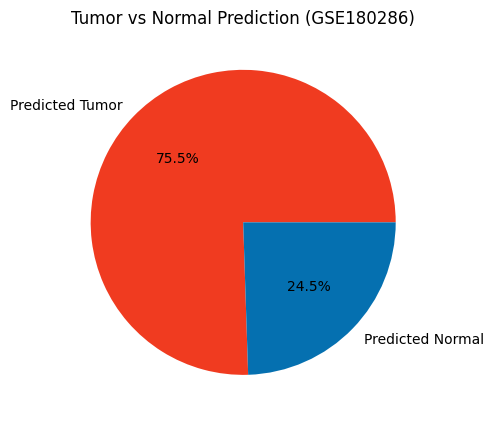

In [12]:
df["tumor_pred_label_mito"].value_counts().plot.pie(
    autopct="%1.1f%%",
    colors=["#f03b20", "#0570b0"],
    figsize=(5, 5)
)
plt.title("Tumor vs Normal Prediction (GSE180286)")
plt.ylabel("")
plt.tight_layout()
plt.show()

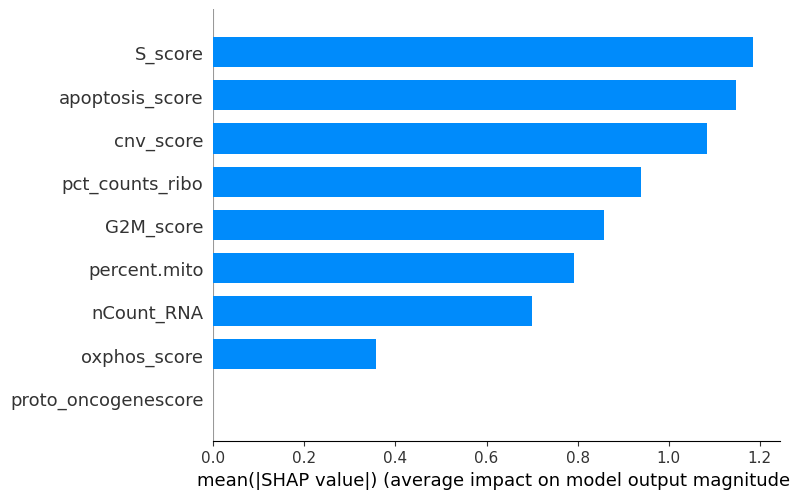

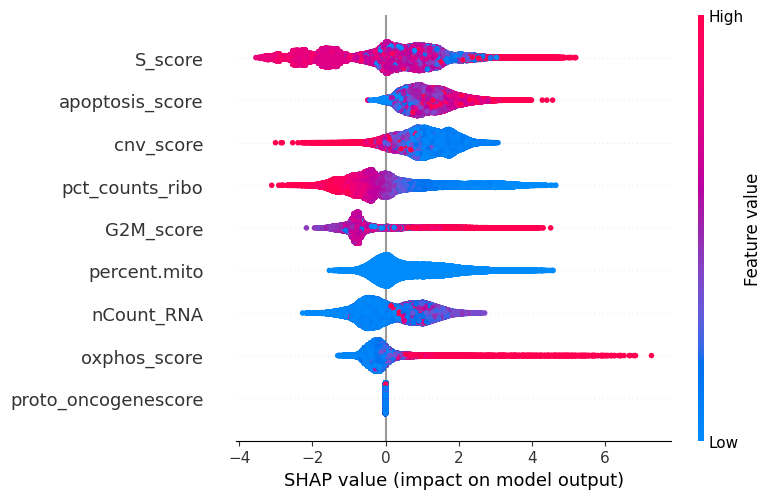

In [13]:
# Features used in the model
features = [
    "apoptosis_score", "oxphos_score",
    "pct_counts_ribo", "nCount_RNA", "cnv_score",
    "proto_oncogenescore", "S_score", "G2M_score", "percent.mito"
]
df_val1 = df.dropna(subset=features)
X_val = df_val1[features]

# Use TreeExplainer instead of the default (which tries to load GPU deps)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)

# Bar summary plot
shap.summary_plot(shap_values, X_val, plot_type="bar")

# Beeswarm summary plot
shap.summary_plot(shap_values, X_val)

In [ ]:
df_val1.to_csv(f"{assets}/GSE180286/GSE180286_predictions.csv", index=True)